In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn import metrics

import torch
import torch.optim as optim

-9.826031844934306 -72.18604237675936


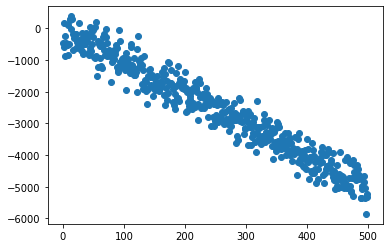

In [2]:
max_x = 500
slope_range = [.1, 10]
slope_direction = np.random.choice([-1,1])
intercept_range = [-80, 80]
residual_var = 100
X = torch.from_numpy(np.arange(max_x))
X = X.type(torch.float64)
m = np.random.uniform(*slope_range) * slope_direction
b = np.random.uniform(*intercept_range)
# m, b = -0.6346013753477167, 52.297166992434484 # mis match in magnitude, learning for b will not be good
# m, b = 5, 5
y = m * X + b + np.random.normal(0, residual_var, len(X)) * m/3
print(m, b)
plt.scatter(X, y)

In [3]:
class Model:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
        self.wait_history = [] # Will hold every parameter after step, add baseline params now
        self.wait_history.append(np.array([float(self.parameters[0][0]),float(self.parameters[0][1])]))
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return self.parameters[0][0] * X + self.parameters[0][1] # Simple line with current m and b weights
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, run all data, adjust the weights once
            loss = self.criterion(self.y_pred, y) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to zero
            loss.backward() # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            self.wait_history.append(np.array([float(self.parameters[0][0]),float(self.parameters[0][1])]))
            if epoch % 10 == 0 or epoch == np.max(range(epochs)):
                print("Epoch: {} - Loss: {}".format(epoch, float(loss)))
    def predict(self, X):
        return self.train(X).detach().numpy()

In [4]:
initial_slope_weights = np.random.normal(.7, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
initial_slope_weights

0.7089767642547514

In [5]:
inital_bias_weight = np.random.normal(0, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
inital_bias_weight

7.001284548612026e-05

In [6]:
#weights are a enumerable tensor.  In our simple r1 maps to r1, it is just 2 trainable paramaters
weights_bias = torch.tensor([initial_slope_weights, inital_bias_weight], requires_grad=True) # requires_grad=True maintains the state for the back prop

In [7]:
#custom optimizer, just plain old Gradiant Decent with a learning rate
class GD_Optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(GD_Optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(-group['lr'], d_p)

        return loss            

In [8]:
model = Model([weights_bias])

#hyper-parameters
epochs = 100
learning_rate = 1e-3

#loss
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.L1Loss()
# criterion = lambda y, y_pred : torch.mean((y - y_pred)**2)
criterion = lambda y, y_pred : torch.mean(abs(y - y_pred))

# back prop gradient decent optimizer
# optimizer = optim.SGD(model.parameters, lr=learning_rate)
# optimizer = optim.SGD(model.parameters, lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters)
optimizer = GD_Optimizer(model.parameters, lr=learning_rate)


model.set_learning_objects(criterion, optimizer)

In [9]:
model.training_loop(epochs, X, y)

Epoch: 10 - Loss: 2174.831553342179
Epoch: 20 - Loss: 1564.7592993235485
Epoch: 30 - Loss: 966.9872003611034
Epoch: 40 - Loss: 428.732283770315
Epoch: 50 - Loss: 280.16584734882656
Epoch: 60 - Loss: 275.39768718715385
Epoch: 70 - Loss: 275.3525016818461
Epoch: 80 - Loss: 275.34252467887035
Epoch: 90 - Loss: 275.3431179413018
Epoch: 99 - Loss: 275.34315468848916
Epoch: 100 - Loss: 275.34195327892746


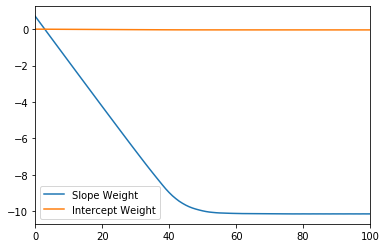

In [10]:
weightsdf = pd.DataFrame(model.wait_history, columns=['Slope Weight', 'Intercept Weight'])
weightsdf.plot()

In [11]:
pred_slope = model.parameters[0][0].item()
pred_intercept = model.parameters[0][1].item()
mbdf = pd.DataFrame({
                        'Model':[pred_slope, pred_intercept],
                        'Actual':[m, b],
                        'Initial Weights':[initial_slope_weights, inital_bias_weight]
                    })
mbdf = mbdf.transpose()
mbdf.columns=['Slope', 'Intercept']
display(mbdf)

y_pred = model.predict(y)
erdf = pd.DataFrame({
                        'Mean Absolute Error':[metrics.mean_absolute_error(y, y_pred)],
                        'Mean Squared Error':[metrics.mean_squared_error(y, y_pred)],
                        'Root Mean Squared Error':[np.sqrt(metrics.mean_squared_error(y, y_pred))],
                        'R2':[metrics.r2_score(y, y_pred)]
                    })
erdf = erdf.transpose()
erdf.columns=['Metric']
display(erdf)

,Slope,Intercept
Model,-10.141589,-0.040954
Actual,-9.826032,-72.186042
Initial Weights,0.708977,0.000070


,Metric
Mean Absolute Error,2.844615e+04
Mean Squared Error,1.073386e+09
Root Mean Squared Error,3.276256e+04
R2,-4.938676e+02


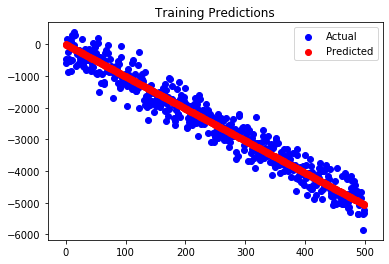

In [12]:
plt.scatter(X, y, color='b', label='Actual')
plt.scatter(X, model.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()